In [9]:
%run Pre-Processing.ipynb

In [10]:
%run Models.ipynb

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from imblearn.over_sampling import ADASYN
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier

In [12]:
SVM_f1 = dict()
KNN_f1 = dict()
RFC_f1 = dict()
LGBM_f1 = dict()
XGB_f1 = dict()
CB_f1 = dict()

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class GaussianBernoulliRBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(GaussianBernoulliRBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        
        # Initialize weights and biases
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)  # Weight matrix
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))               # Hidden layer bias
        self.v_bias = nn.Parameter(torch.zeros(n_visible))              # Visible layer bias
        
    def sample_h(self, v):
        """Sample the hidden layer given visible layer v."""
        # Compute probabilities for hidden units
        h_prob = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return h_prob, torch.bernoulli(h_prob)

    def sample_v(self, h):
        """Sample the visible layer given hidden layer h."""
        # For continuous data, we use Gaussian visible units
        v_mean = torch.matmul(h, self.W) + self.v_bias
        # Sample from a Gaussian distribution with mean v_mean
        v_sample = v_mean + torch.randn(v_mean.size())  # Adding Gaussian noise
        return v_sample, v_mean

    def gibbs_sampling(self, v):
        """Perform Gibbs sampling: visible -> hidden -> visible."""
        h_prob, h_sample = self.sample_h(v)
        v_sample, v_mean = self.sample_v(h_sample)
        return v_sample, v_mean

    def contrastive_divergence(self, v, k=1):
        """Perform Contrastive Divergence with k Gibbs sampling steps."""
        v0 = v
        for step in range(k):
            v_sample, _ = self.gibbs_sampling(v0)
        return v_sample

    def forward(self, v):
        """Run the forward pass to get the final reconstructed visible layer."""
        v_sample = self.contrastive_divergence(v)
        return v_sample

    def reconstruction_loss(self, v, v_reconstructed):
        """Mean Squared Error Loss for reconstruction."""
        return torch.mean((v - v_reconstructed) ** 2)

    def train_rbm(self, data, lr=0.01, epochs=100, batch_size=64, k=1):
        optimizer = optim.SGD(self.parameters(), lr=lr)
        
        for epoch in range(epochs):
            total_loss = 0.0
            for i in range(0, data.size(0), batch_size):
                v_batch = data[i:i + batch_size]
                
                # Forward pass: Contrastive Divergence
                v_reconstructed = self(v_batch)
                
                # Compute the reconstruction loss
                loss = self.reconstruction_loss(v_batch, v_reconstructed)
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            if(epoch%10==0):
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / (data.size(0) // batch_size):.6f}')

    def fit(self, X, lr=0.01, epochs=100, batch_size=64, k=1):
        """Fit the RBM model to the dataset."""
        # Convert the dataset into a PyTorch tensor
        X_tensor = torch.tensor(X, dtype=torch.float32)
        # Train the model
        self.train_rbm(X_tensor, lr=lr, epochs=epochs, batch_size=batch_size, k=k)

    def transform(self, X):
        """Transform input data using the hidden representations."""
        X_tensor = torch.tensor(X, dtype=torch.float32)
        # Sample hidden units based on input visible units
        _, h_sample = self.sample_h(X_tensor)
        return h_sample.detach().numpy()

    def reconstruct(self, X):
        """Reconstruct visible units from hidden units."""
        X_tensor = torch.tensor(X, dtype=torch.float32)
        # Perform Gibbs sampling to reconstruct visible units
        v_sample, _ = self.gibbs_sampling(X_tensor)
        return v_sample.detach().numpy()

In [16]:
for x in range(71, 10, -10):
    num_feature = x
    n_visible = X_train_resampled.shape[1]
    print("No of feature", num_feature)
    selector = GaussianBernoulliRBM(n_visible, num_feature)
    selector.fit(X_train_resampled, lr=0.01, epochs=50, batch_size=64, k=1)
    X_train_selected = selector.transform(X_train_resampled)
    X_test_selected = selector.transform(X_test_transformed)
    SVM_f1[x] = SVM_selector(X_train_selected, y_train_resampled, X_test_selected, y_test)
    KNN_f1[x] = KNN_Classifier(X_train_selected, y_train_resampled, X_test_selected, y_test)
    RFC_f1[x] = RandomForest_Classifier(X_train_selected, y_train_resampled, X_test_selected, y_test)
    LGBM_f1[x] = LGBM_Classifier(X_train_selected, y_train_resampled, X_test_selected, y_test)
    XGB_f1[x] = XGB_Classifier(X_train_selected, y_train_resampled, X_test_selected, y_test)
    CB_f1[x] = CatBoost_Classifier(X_train_selected, y_train_resampled, X_test_selected, y_test)

No of feature 71
Epoch 1/50, Loss: 1.527098
Epoch 11/50, Loss: 1.216289
Epoch 21/50, Loss: 1.209343
Epoch 31/50, Loss: 1.212360
Epoch 41/50, Loss: 1.213633
SVM Model:-
[LibSVM]

C:\Users\gauta\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Making predictions...

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9355    0.9772    0.9559    103560
      Attack     0.1812    0.0696    0.1006      7496

    accuracy                         0.9160    111056
   macro avg     0.5584    0.5234    0.5283    111056
weighted avg     0.8846    0.9160    0.8982    111056


Confusion Matrix:
[[101201   2359]
 [  6974    522]]
KNN model
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9467    0.9462    0.9464    103560
      Attack     0.2620    0.2641    0.2631      7496

    accuracy                         0.9001    111056
   macro avg     0.6044    0.6051    0.6048    111056
weighted avg     0.9005    0.9001    0.9003    111056

Confusion Matrix:
[[97984  5576]
 [ 5516  1980]]
Random Forest:-


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.9s finished


Classification Report:
              precision    recall  f1-score   support

      Normal     0.9976    0.7469    0.8543    103560
      Attack     0.2181    0.9755    0.3565      7496

    accuracy                         0.7623    111056
   macro avg     0.6079    0.8612    0.6054    111056
weighted avg     0.9450    0.7623    0.8207    111056

Confusion Matrix:
[[77350 26210]
 [  184  7312]]
LGBM Model:-
[LightGBM] [Info] Number of positive: 83069, number of negative: 414022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 142
[LightGBM] [Info] Number of data points in the train set: 497091, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167110 -> initscore=-1.606248
[LightGBM] [Info] Start training from score -1.606248
Classification Report:
      

C:\Users\gauta\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Making predictions...

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9365    0.9834    0.9594    103560
      Attack     0.2555    0.0786    0.1202      7496

    accuracy                         0.9224    111056
   macro avg     0.5960    0.5310    0.5398    111056
weighted avg     0.8905    0.9224    0.9027    111056


Confusion Matrix:
[[101844   1716]
 [  6907    589]]
KNN model
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9466    0.9495    0.9481    103560
      Attack     0.2720    0.2605    0.2661      7496

    accuracy                         0.9030    111056
   macro avg     0.6093    0.6050    0.6071    111056
weighted avg     0.9011    0.9030    0.9021    111056

Confusion Matrix:
[[98333  5227]
 [ 5543  1953]]
Random Forest:-


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   55.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished


Classification Report:
              precision    recall  f1-score   support

      Normal     0.9967    0.7535    0.8582    103560
      Attack     0.2208    0.9650    0.3594      7496

    accuracy                         0.7678    111056
   macro avg     0.6087    0.8593    0.6088    111056
weighted avg     0.9443    0.7678    0.8245    111056

Confusion Matrix:
[[78036 25524]
 [  262  7234]]
LGBM Model:-
[LightGBM] [Info] Number of positive: 83069, number of negative: 414022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 497091, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167110 -> initscore=-1.606248
[LightGBM] [Info] Start training from score -1.606248
Classification Report:
      

C:\Users\gauta\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Making predictions...

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9364    0.9836    0.9594    103560
      Attack     0.2527    0.0767    0.1177      7496

    accuracy                         0.9224    111056
   macro avg     0.5946    0.5301    0.5385    111056
weighted avg     0.8902    0.9224    0.9026    111056


Confusion Matrix:
[[101860   1700]
 [  6921    575]]
KNN model
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9464    0.9537    0.9500    103560
      Attack     0.2841    0.2537    0.2680      7496

    accuracy                         0.9065    111056
   macro avg     0.6152    0.6037    0.6090    111056
weighted avg     0.9017    0.9065    0.9040    111056

Confusion Matrix:
[[98766  4794]
 [ 5594  1902]]
Random Forest:-


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.9s finished


Classification Report:
              precision    recall  f1-score   support

      Normal     0.9968    0.7569    0.8604    103560
      Attack     0.2235    0.9669    0.3631      7496

    accuracy                         0.7710    111056
   macro avg     0.6102    0.8619    0.6118    111056
weighted avg     0.9446    0.7710    0.8269    111056

Confusion Matrix:
[[78381 25179]
 [  248  7248]]
LGBM Model:-
[LightGBM] [Info] Number of positive: 83069, number of negative: 414022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102
[LightGBM] [Info] Number of data points in the train set: 497091, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167110 -> initscore=-1.606248
[LightGBM] [Info] Start training from score -1.606248
Classification Report:
      

C:\Users\gauta\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Making predictions...

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9362    0.9752    0.9553    103560
      Attack     0.1929    0.0820    0.1151      7496

    accuracy                         0.9149    111056
   macro avg     0.5646    0.5286    0.5352    111056
weighted avg     0.8860    0.9149    0.8986    111056


Confusion Matrix:
[[100987   2573]
 [  6881    615]]
KNN model
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9437    0.9627    0.9531    103560
      Attack     0.2866    0.2068    0.2402      7496

    accuracy                         0.9117    111056
   macro avg     0.6152    0.5848    0.5967    111056
weighted avg     0.8994    0.9117    0.9050    111056

Confusion Matrix:
[[99702  3858]
 [ 5946  1550]]
Random Forest:-


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished


Classification Report:
              precision    recall  f1-score   support

      Normal     0.9970    0.7457    0.8532    103560
      Attack     0.2162    0.9691    0.3535      7496

    accuracy                         0.7608    111056
   macro avg     0.6066    0.8574    0.6034    111056
weighted avg     0.9443    0.7608    0.8195    111056

Confusion Matrix:
[[77226 26334]
 [  232  7264]]
LGBM Model:-
[LightGBM] [Info] Number of positive: 83069, number of negative: 414022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 497091, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167110 -> initscore=-1.606248
[LightGBM] [Info] Start training from score -1.606248
Classification Report:
       

C:\Users\gauta\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Making predictions...

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9362    0.9746    0.9550    103560
      Attack     0.1913    0.0831    0.1159      7496

    accuracy                         0.9144    111056
   macro avg     0.5638    0.5288    0.5355    111056
weighted avg     0.8860    0.9144    0.8984    111056


Confusion Matrix:
[[100927   2633]
 [  6873    623]]
KNN model
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9407    0.9756    0.9578    103560
      Attack     0.3079    0.1498    0.2016      7496

    accuracy                         0.9199    111056
   macro avg     0.6243    0.5627    0.5797    111056
weighted avg     0.8980    0.9199    0.9068    111056

Confusion Matrix:
[[101036   2524]
 [  6373   1123]]
Random Forest:-


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   40.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished


Classification Report:
              precision    recall  f1-score   support

      Normal     0.9972    0.7531    0.8582    103560
      Attack     0.2216    0.9712    0.3609      7496

    accuracy                         0.7678    111056
   macro avg     0.6094    0.8622    0.6095    111056
weighted avg     0.9449    0.7678    0.8246    111056

Confusion Matrix:
[[77994 25566]
 [  216  7280]]
LGBM Model:-
[LightGBM] [Info] Number of positive: 83069, number of negative: 414022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 497091, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167110 -> initscore=-1.606248
[LightGBM] [Info] Start training from score -1.606248
Classification Report:
       

C:\Users\gauta\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Making predictions...

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9365    0.9779    0.9568    103560
      Attack     0.2160    0.0840    0.1210      7496

    accuracy                         0.9176    111056
   macro avg     0.5762    0.5310    0.5389    111056
weighted avg     0.8879    0.9176    0.9004    111056


Confusion Matrix:
[[101273   2287]
 [  6866    630]]
KNN model
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9406    0.9787    0.9593    103560
      Attack     0.3321    0.1462    0.2030      7496

    accuracy                         0.9225    111056
   macro avg     0.6364    0.5625    0.5812    111056
weighted avg     0.8995    0.9225    0.9082    111056

Confusion Matrix:
[[101356   2204]
 [  6400   1096]]
Random Forest:-


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   32.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished


Classification Report:
              precision    recall  f1-score   support

      Normal     0.9986    0.7216    0.8378    103560
      Attack     0.2040    0.9857    0.3381      7496

    accuracy                         0.7395    111056
   macro avg     0.6013    0.8537    0.5879    111056
weighted avg     0.9449    0.7395    0.8041    111056

Confusion Matrix:
[[74732 28828]
 [  107  7389]]
LGBM Model:-
[LightGBM] [Info] Number of positive: 83069, number of negative: 414022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42
[LightGBM] [Info] Number of data points in the train set: 497091, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167110 -> initscore=-1.606248
[LightGBM] [Info] Start training from score -1.606248
Classification Report:
       

C:\Users\gauta\anaconda3\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Making predictions...

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9358    0.9668    0.9511    103560
      Attack     0.1538    0.0832    0.1080      7496

    accuracy                         0.9072    111056
   macro avg     0.5448    0.5250    0.5295    111056
weighted avg     0.8830    0.9072    0.8942    111056


Confusion Matrix:
[[100126   3434]
 [  6872    624]]
KNN model
Classification Report:
              precision    recall  f1-score   support

      Normal     0.9395    0.9859    0.9621    103560
      Attack     0.3850    0.1223    0.1857      7496

    accuracy                         0.9276    111056
   macro avg     0.6622    0.5541    0.5739    111056
weighted avg     0.9020    0.9276    0.9097    111056

Confusion Matrix:
[[102095   1465]
 [  6579    917]]
Random Forest:-


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished


Classification Report:
              precision    recall  f1-score   support

      Normal     0.9988    0.7177    0.8353    103560
      Attack     0.2022    0.9880    0.3356      7496

    accuracy                         0.7360    111056
   macro avg     0.6005    0.8529    0.5854    111056
weighted avg     0.9450    0.7360    0.8015    111056

Confusion Matrix:
[[74330 29230]
 [   90  7406]]
LGBM Model:-
[LightGBM] [Info] Number of positive: 83069, number of negative: 414022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22
[LightGBM] [Info] Number of data points in the train set: 497091, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.167110 -> initscore=-1.606248
[LightGBM] [Info] Start training from score -1.606248
Classification Report:
       

In [17]:
def print_plot(dictionary):
    keys = list(dictionary.keys())
    values = list(dictionary.values())
    plt.figure(figsize=(8, 6))
    plt.plot(keys, values, marker='o', linestyle='-', color='b')
    plt.xlabel('No of Features')
    plt.ylabel('F1-Score')
    plt.title('No of Features vs F1-Score')
    plt.grid(True)
    plt.show()

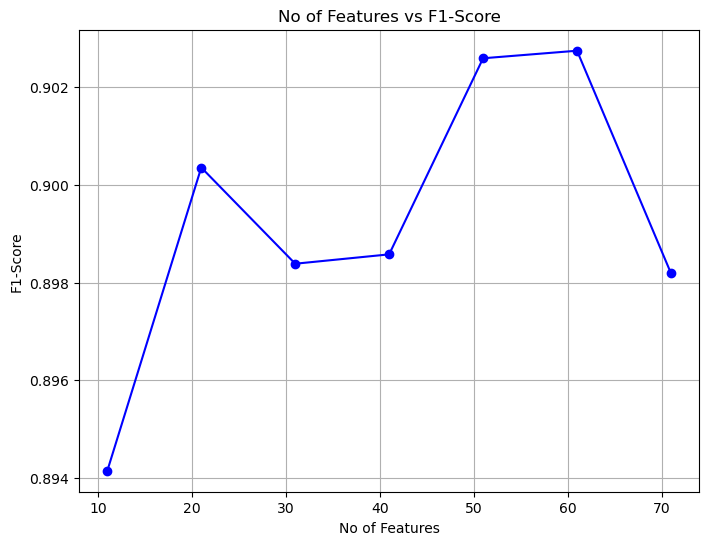

In [18]:
print_plot(SVM_f1)

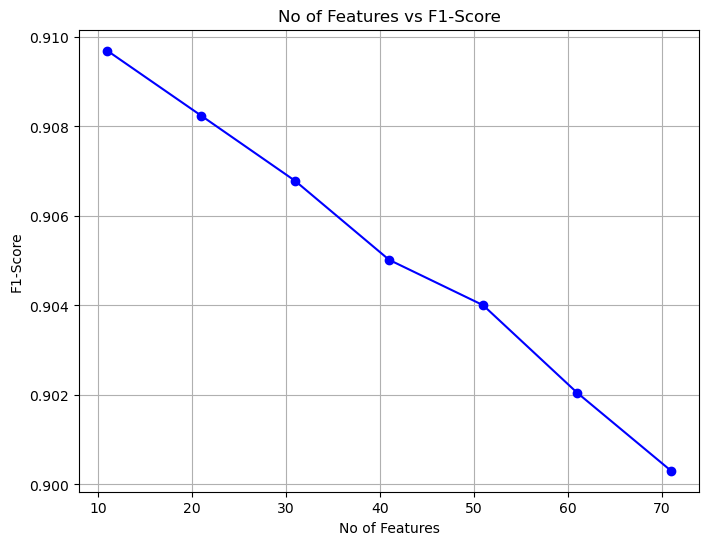

In [19]:
print_plot(KNN_f1)

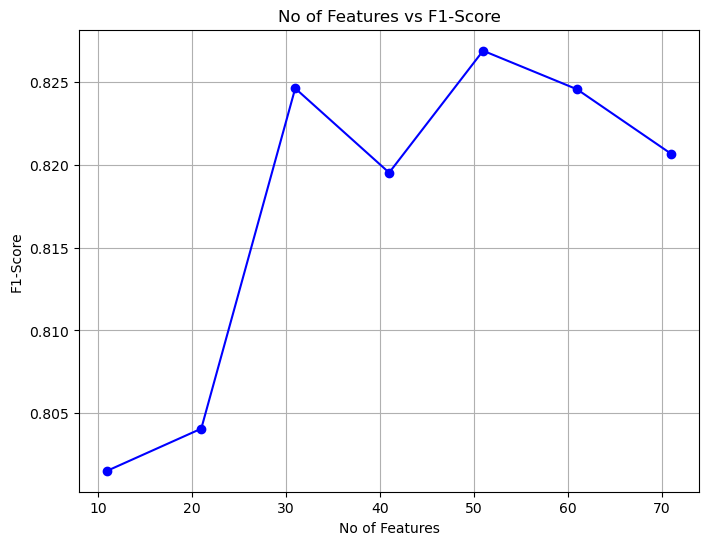

In [20]:
print_plot(RFC_f1)

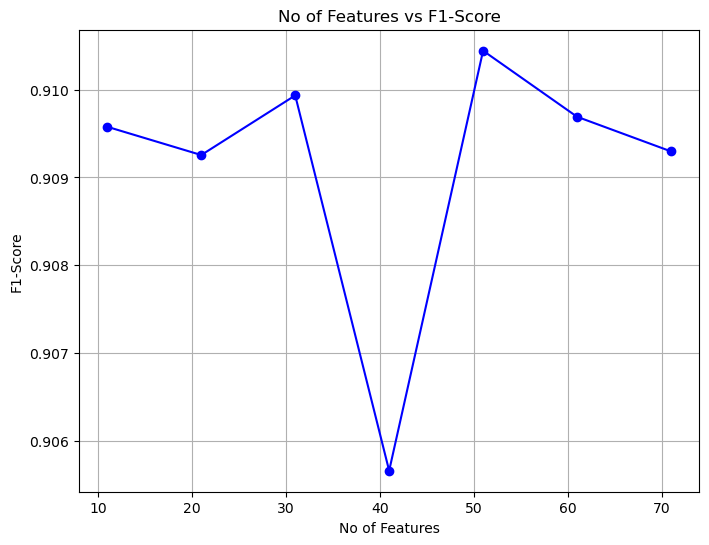

In [21]:
print_plot(LGBM_f1)

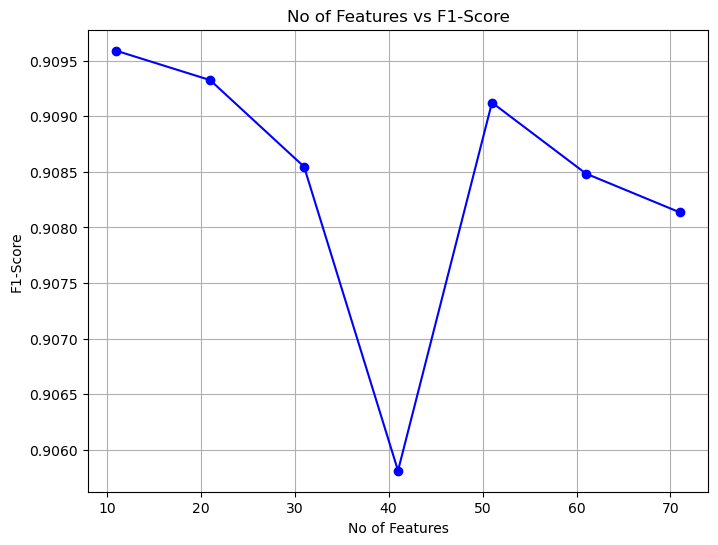

In [22]:
print_plot(XGB_f1)

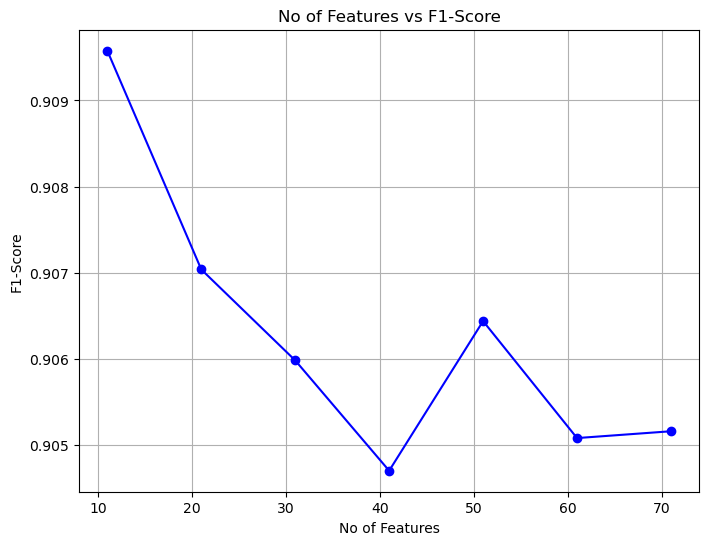

In [23]:
print_plot(CB_f1)